In [36]:
import numpy as np
import botorch
import torch

torch.set_default_dtype(torch.double)

from botorch.acquisition.analytic import LogExpectedImprovement, UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize 
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.logei import qLogNoisyExpectedImprovement

from gpytorch.kernels import MaternKernel

import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

import json
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn import metrics

In [2]:
with open('/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/constants_2024_10_17_randomV4.json', 'rt') as f:
    synth_constants = json.load(f) 

In [3]:
synth_constants

{'TEOS': {'minimum_volume_fraction': 0.01,
  'maximum_volume_fraction': 0.15,
  'density': 0.933,
  'stock_concentration': 4.48,
  'molecular_weight': 208.33,
  'stock_source': 'Benson Jug',
  'manufacturer': 'Aldrich',
  'lot_number': 'WXBC2231V'},
 'water': {'minimum_volume_fraction': 0.005,
  'maximum_volume_fraction': 0.15,
  'density': 0.9982,
  'stock_concentration': 55.51,
  'molecular_weight': 18.015,
  'stock_source': 'Benson DI machine',
  'manufacturer': 'nan',
  'lot_number': 'nan'},
 'ammonia': {'minimum_volume_fraction': 0.005,
  'maximum_volume_fraction': 0.11,
  'density': 0.9,
  'molecular_weight': 35.046,
  'stock_concentration': 55.51,
  'stock_source': 'Benson vial',
  'manufacturer': 'Fisher scientific',
  'lot_number': '146981'},
 'ethanol': {'minimum_volume_fraction': 0.1,
  'maximum_volume_fraction': 0.1,
  'density': 0.789,
  'molecular_weight': 46.07,
  'stock_concentration': 55.51,
  'stock_source': 'Benson aliquot from MolES',
  'manufacturer': 'nan',
  'lot

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
bounds['ethanol'] = (0,1)

In [6]:
synth_data = pd.read_csv('synth_table_with_rmsedist_10_28_24.csv')

In [7]:
synth_data = synth_data[~synth_data['rmse_log_distance'].isna()]

In [8]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = synth_data['rmse_log_distance']

In [9]:
x_data

,teos_vol_frac,ammonia_vol_frac,water_vol_frac
2,0.011765,0.037647,0.028824
3,0.106408,0.005291,0.134039
4,0.058789,0.030570,0.008818
5,0.124191,0.007063,0.035903
6,0.059377,0.058789,0.019400
...,...,...,...
119,0.066489,0.037489,0.139971
120,0.086145,0.093377,0.021210
121,0.140118,0.044781,0.029737
122,0.083087,0.100497,0.139695


## Data normalization etc.

In [10]:
y_data[y_data ==50] = 5

In [11]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[0], [5]]))

In [12]:
y_data_norm = y_data_norm.reshape((-1,1))

In [13]:
bounds_torch = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [14]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [15]:
x_data_norm = normalize(x_data_torch, bounds_torch)

In [16]:
tsne = TSNE()

In [17]:
x_tsne = tsne.fit_transform(x_data_norm)

Text(0.5, 1.0, 'TSNE plot of initial data')

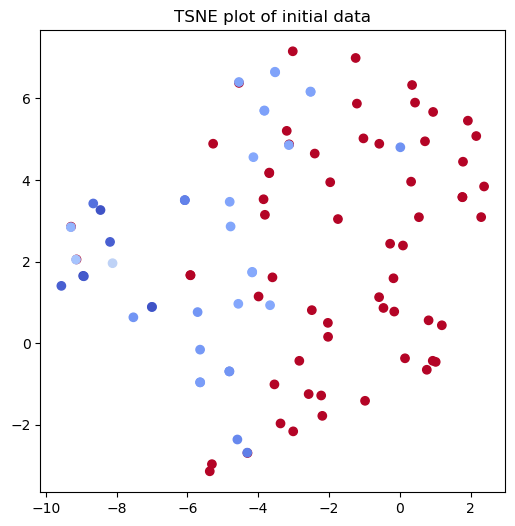

In [18]:
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x_tsne[:,0], x_tsne[:,1], c = y_data, cmap = plt.cm.coolwarm)
ax.set_title("TSNE plot of initial data")


## Set up model

In [20]:
nu = 5/2

In [21]:
kernel = MaternKernel(nu = nu, ard_num_dims = 3)
gp_model = SingleTaskGP(x_data_norm, y_data_norm, outcome_transform=Standardize(m=1), covar_module=kernel).to(x_data_norm)

mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

In [22]:
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [23]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [24]:
posterior = gp_model.posterior(x_data_norm)

In [25]:
mean = posterior.mean.detach().reshape(-1).tolist()

In [26]:
std = posterior.variance.detach().reshape(-1).tolist()

In [27]:
r2 = metrics.r2_score(y_data_norm, mean)

In [28]:
print('r2 score: ', r2)

r2 score:  0.7760648535591651


Text(0, 0.5, 'GPR fit')

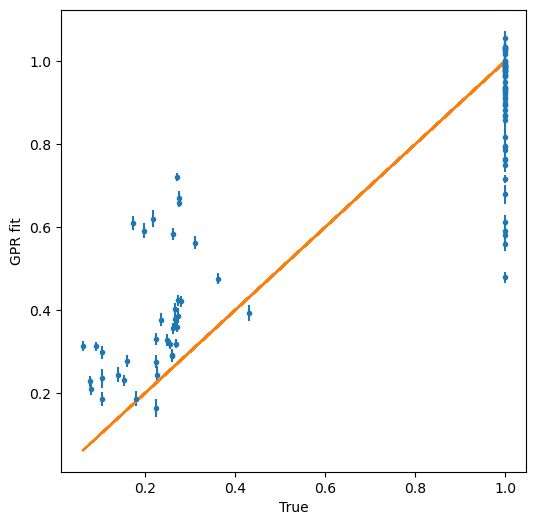

In [29]:

fig, ax = plt.subplots(figsize = (6,6))
ax.errorbar(y_data_norm, mean, yerr=std, ls = '', marker = '.')
ax.plot(y_data_norm, y_data_norm)
ax.set_xlabel('True')
ax.set_ylabel('GPR fit')


In [30]:
kernel

MaternKernel(
  (raw_lengthscale_constraint): Positive()
)

In [31]:
kernel.lengthscale

tensor([[0.2027, 0.3214, 0.4225]], grad_fn=<SoftplusBackward0>)

In [32]:
kernel.eps

1e-06

### Set up BO things

In [35]:
sampler = SobolQMCNormalSampler(torch.Size([1024]))

In [ ]:
acqf = qLogNoisyExpectedImprovement(